In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    #total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss*modulating_number
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0616/weights_KD_segformer_0616_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.2
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 [======>.......................] - ETA: 11s - loss: 0.0915

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 6s 604ms/step - loss: 0.0706
Average validation loss: 0.6886980533599854
4/4 [==============================] - 6s 617ms/step - loss: 0.0706 - val_loss: 0.6887
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 8s 607ms/step - loss: 0.0502 - val_loss: 0.6887
Average validation loss: 0.5715019106864929
4/4 [==============================] - 8s 621ms/step - loss: 0.0502 - val_loss: 0.6301
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 11s 592ms/step - loss: 0.0376 - val_loss: 0.6301
Average validation loss: 0.5161539316177368
4/4 [==============================] - 11s 604ms/step - loss: 0.0376 - val_loss

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 711ms/step - loss: 4.8356e-05
Average validation loss: 3.3344846883665014e-07
8/8 [==============================] - 6s 721ms/step - loss: 4.8356e-05 - val_loss: 3.3345e-07
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 12s 716ms/step - loss: 4.7157e-05 - val_loss: 3.3345e-07
Average validation loss: 1.8819044271367602e-05
8/8 [==============================] - 12s 726ms/step - loss: 4.7157e-05 - val_loss: 9.5762e-06
Epoch 3/10
8/8 [==============================] - 17s 690ms/step - loss: 4.6150e-05 - val_loss: 9.5762e-06
Average validation loss: 0.000887244677869603
8/8 [==============================] - 17s 700ms/step - loss: 4.6150e-05 - val_loss: 3.0213e-04
Epoch 4/10
8/8 [==============================] - 23s 697ms/step - loss: 4.5308e-05 - val_loss: 3.0213e-04
Av

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 8s 704ms/step - loss: 7.9457e-05
Average validation loss: 0.04160643838501225
12/12 [==============================] - 9s 713ms/step - loss: 7.9457e-05 - val_loss: 0.0416
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 17s 715ms/step - loss: 8.1476e-05 - val_loss: 0.0416
Average validation loss: 0.028096573427319527
12/12 [==============================] - 17s 724ms/step - loss: 8.1476e-05 - val_loss: 0.0349
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_15.pth'.
Epoch 3/10
12/12 [==============================] - 26s 703ms/step - loss: 7.9871e-05 - val_loss: 0.0349
Average validation loss: 0.06042952400942644
12/12 [==============================] - 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 11s 705ms/step - loss: 6.1136e-05
Average validation loss: 0.13421095918212697
16/16 [==============================] - 11s 714ms/step - loss: 6.1136e-05 - val_loss: 0.1342
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 24s 751ms/step - loss: 5.8820e-05 - val_loss: 0.1342
Average validation loss: 0.02359420518769184
16/16 [==============================] - 24s 761ms/step - loss: 5.8820e-05 - val_loss: 0.0789
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_20.pth'.
Epoch 3/10
16/16 [==============================] - 36s 746ms/step - loss: 5.7263e-05 - val_loss: 0.0789
Average validation loss: 0.09324767148063984
16/16 [==============================] -

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 14s 711ms/step - loss: 4.1114e-05
Average validation loss: 0.07654894888401031
20/20 [==============================] - 14s 720ms/step - loss: 4.1114e-05 - val_loss: 0.0765
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 29s 699ms/step - loss: 3.6446e-05 - val_loss: 0.0765
Average validation loss: 0.035775721195386724
20/20 [==============================] - 29s 711ms/step - loss: 3.6446e-05 - val_loss: 0.0562
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_25.pth'.
Epoch 3/10
20/20 [==============================] - 43s 708ms/step - loss: 3.5445e-05 - val_loss: 0.0562
Average validation loss: 0.038021284714341165
20/20 [==============================]

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 17s 716ms/step - loss: 5.7269e-05
Average validation loss: 0.05063002991179625
24/24 [==============================] - 18s 728ms/step - loss: 5.7269e-05 - val_loss: 0.0506
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 35s 721ms/step - loss: 4.7878e-05 - val_loss: 0.0506
Average validation loss: 0.01599978283047676
24/24 [==============================] - 35s 730ms/step - loss: 4.7878e-05 - val_loss: 0.0333
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_30.pth'.
Epoch 3/10
24/24 [==============================] - 52s 704ms/step - loss: 4.2410e-05 - val_loss: 0.0333
Average validation loss: 0.01748883134375016
24/24 [==============================] -

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 28s 701ms/step - loss: 1.4586e-04
Average validation loss: 0.03908747024834156
40/40 [==============================] - 28s 712ms/step - loss: 1.4586e-04 - val_loss: 0.0391
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 57s 707ms/step - loss: 1.0993e-04 - val_loss: 0.0391
Average validation loss: 0.028764593973755838
40/40 [==============================] - 57s 717ms/step - loss: 1.0993e-04 - val_loss: 0.0339
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_50.pth'.
Epoch 3/10
40/40 [==============================] - 86s 714ms/step - loss: 9.3353e-05 - val_loss: 0.0339
Average validation loss: 0.0262043546885252
40/40 [==============================] -

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 34s 706ms/step - loss: 5.2390e-05
Average validation loss: 0.021480073725494247
48/48 [==============================] - 34s 716ms/step - loss: 5.2390e-05 - val_loss: 0.0215
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 69s 712ms/step - loss: 4.1151e-05 - val_loss: 0.0215
Average validation loss: 0.027702011517249048
48/48 [==============================] - 69s 723ms/step - loss: 4.1151e-05 - val_loss: 0.0246
Epoch 3/10
48/48 [==============================] - 103s 709ms/step - loss: 3.4131e-05 - val_loss: 0.0246
Average validation loss: 0.01959267774752031
48/48 [==============================] - 104s 719ms/step - loss: 3.4131e-05 - val_loss: 0.0229
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 40s 710ms/step - loss: 7.9559e-05
Average validation loss: 0.027539825466062342
56/56 [==============================] - 40s 721ms/step - loss: 7.9559e-05 - val_loss: 0.0275
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 80s 702ms/step - loss: 6.0279e-05 - val_loss: 0.0275
Average validation loss: 0.018590380379464477
56/56 [==============================] - 80s 712ms/step - loss: 6.0279e-05 - val_loss: 0.0231
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_70.pth'.
Epoch 3/10
56/56 [==============================] - 120s 701ms/step - loss: 4.7933e-05 - val_loss: 0.0231
Average validation loss: 0.02009615771073316
56/56 [==============================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 45s 703ms/step - loss: 3.6417e-05
Average validation loss: 0.1136258104108947
64/64 [==============================] - 46s 713ms/step - loss: 3.6417e-05 - val_loss: 0.1136
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 91s 704ms/step - loss: 2.4896e-05 - val_loss: 0.1136
Average validation loss: 0.011491773737361655
64/64 [==============================] - 91s 714ms/step - loss: 2.4896e-05 - val_loss: 0.0626
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_80.pth'.
Epoch 3/10
64/64 [==============================] - 136s 701ms/step - loss: 2.1058e-05 - val_loss: 0.0626
Average validation loss: 0.09004660343759952
64/64 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 51s 708ms/step - loss: 3.7206e-05
Average validation loss: 0.021894518958611622
72/72 [==============================] - 52s 719ms/step - loss: 3.7206e-05 - val_loss: 0.0219
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 102s 704ms/step - loss: 2.6032e-05 - val_loss: 0.0219
Average validation loss: 0.010507700473277105
72/72 [==============================] - 103s 714ms/step - loss: 2.6032e-05 - val_loss: 0.0162
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_90.pth'.
Epoch 3/10
72/72 [==============================] - 154s 702ms/step - loss: 2.0055e-05 - val_loss: 0.0162
Average validation loss: 0.013688811463200383
72/72 [===========================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 56s 704ms/step - loss: 2.6933e-05
Average validation loss: 0.010901519015897065
80/80 [==============================] - 57s 714ms/step - loss: 2.6933e-05 - val_loss: 0.0109
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 114s 705ms/step - loss: 2.0807e-05 - val_loss: 0.0109
Average validation loss: 0.028936211159452795
80/80 [==============================] - 114s 715ms/step - loss: 2.0807e-05 - val_loss: 0.0199
Epoch 3/10
80/80 [==============================] - 171s 706ms/step - loss: 1.6497e-05 - val_loss: 0.0199
Average validation loss: 0.014950686367228627
80/80 [==============================] - 172s 716ms/step - loss: 1.6497e-05 - val_loss: 0.0183
Epoch 4/10
80/80 [==============================] - 228s 702ms/step - loss: 1.3847e-05 - val_loss: 0.0183
Average 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 74s 767ms/step - loss: 6.2621e-05
Average validation loss: 0.024700031576988597
96/96 [==============================] - 75s 778ms/step - loss: 6.2621e-05 - val_loss: 0.0247
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 148s 767ms/step - loss: 4.5689e-05 - val_loss: 0.0247
Average validation loss: 0.02080855908570811
96/96 [==============================] - 149s 778ms/step - loss: 4.5689e-05 - val_loss: 0.0228
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_120.pth'.
Epoch 3/10
96/96 [==============================] - 223s 771ms/step - loss: 3.4997e-05 - val_loss: 0.0228
Average validation loss: 0.020131682152471814
96/96 [==========================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 92s 768ms/step - loss: 3.8745e-05
Average validation loss: 0.019609995124240717
120/120 [==============================] - 94s 779ms/step - loss: 3.8745e-05 - val_loss: 0.0196
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 185s 765ms/step - loss: 2.8169e-05 - val_loss: 0.0196
Average validation loss: 0.00963470145749549
120/120 [==============================] - 187s 776ms/step - loss: 2.8169e-05 - val_loss: 0.0146
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 279s 766ms/step - loss: 2.2248e-05 - val_loss: 0.0146
Average validation loss: 0.0109302234215041
120/120 [================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 101s 699ms/step - loss: 2.5869e-05
Average validation loss: 0.019022114245065797
144/144 [==============================] - 102s 709ms/step - loss: 2.5869e-05 - val_loss: 0.0190
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 204s 705ms/step - loss: 2.1107e-05 - val_loss: 0.0190
Average validation loss: 0.04910037537208862
144/144 [==============================] - 205s 715ms/step - loss: 2.1107e-05 - val_loss: 0.0341
Epoch 3/10
144/144 [==============================] - 307s 705ms/step - loss: 1.6884e-05 - val_loss: 0.0341
Average validation loss: 0.010672454657550488
144/144 [==============================] - 308s 715ms/step - loss: 1.6884e-05 - val_loss: 0.0263
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_K

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 112s 699ms/step - loss: 1.3152e-05
Average validation loss: 0.07489564860370593
160/160 [==============================] - 114s 709ms/step - loss: 1.3152e-05 - val_loss: 0.0749
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 225s 696ms/step - loss: 1.0076e-05 - val_loss: 0.0749
Average validation loss: 0.00843428581210901
160/160 [==============================] - 226s 706ms/step - loss: 1.0076e-05 - val_loss: 0.0417
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_200.pth'.
Epoch 3/10
160/160 [==============================] - 339s 702ms/step - loss: 8.0503e-06 - val_loss: 0.0417
Average validation loss: 0.05873865228386421
160/160 [==============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 141s 703ms/step - loss: 5.3200e-05
Average validation loss: 0.012177116414532065
200/200 [==============================] - 143s 713ms/step - loss: 5.3200e-05 - val_loss: 0.0122
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 283s 701ms/step - loss: 3.8799e-05 - val_loss: 0.0122
Average validation loss: 0.013542053692508488
200/200 [==============================] - 285s 711ms/step - loss: 3.8799e-05 - val_loss: 0.0129
Epoch 3/10
200/200 [==============================] - 425s 702ms/step - loss: 3.0287e-05 - val_loss: 0.0129
Average validation loss: 0.010592691372148693
200/200 [==============================] - 427s 712ms/step - loss: 3.0287e-05 - val_loss: 0.0121
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 3:04 - loss: 2.1799e-07

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 169s 704ms/step - loss: 2.6484e-05
Average validation loss: 0.021280512042964498
240/240 [==============================] - 171s 714ms/step - loss: 2.6484e-05 - val_loss: 0.0213
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 340s 701ms/step - loss: 1.8128e-05 - val_loss: 0.0213
Average validation loss: 0.011104193968882707
240/240 [==============================] - 342s 711ms/step - loss: 1.8128e-05 - val_loss: 0.0162
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_300.pth'.
Epoch 3/10
240/240 [==============================] - 511s 705ms/step - loss: 1.4608e-05 - val_loss: 0.0162
Average validation loss: 0.02361955555000653
240/240 [============

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.09748103435579153, 0.040926854474079705, 0.08261453577299192, 0.0580976358278906, 0.035735709169819524, 0.028001105122760536, 0.0305178674976014, 0.019053753423158924, 0.030040086473844502, 0.02982109093069127, 0.026007229909931383, 0.016714662756727193, 0.017131711409941394, 0.014782678512611409, 0.02005259657013514, 0.01485593532802568, 0.016692198597292006, 0.02531140319747123]
std_val_losses =  [0.17621163886033434, 0.030243205728612232, 0.1384134721927047, 0.03483765810637714, 0.028135734797207806, 0.026622715595289583, 0.021350371684441573, 0.015345889434199683, 0.062402452607819354, 0.03734365328878227, 0.04939069044141055, 0.02830476193737106, 0.010891999977617283, 0.011167711495916697, 0.02222262034256949, 0.015053706917673638, 0.019095473107537793, 0.040848904475060184]


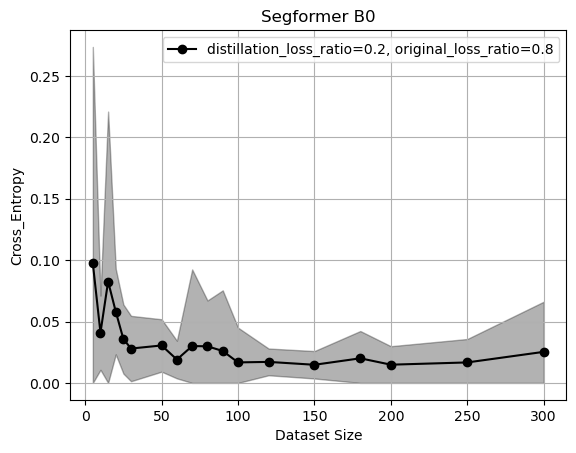

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0616')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.png"))

plt.show()